In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config import *


## Reproducibility

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_5607/2265339157.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


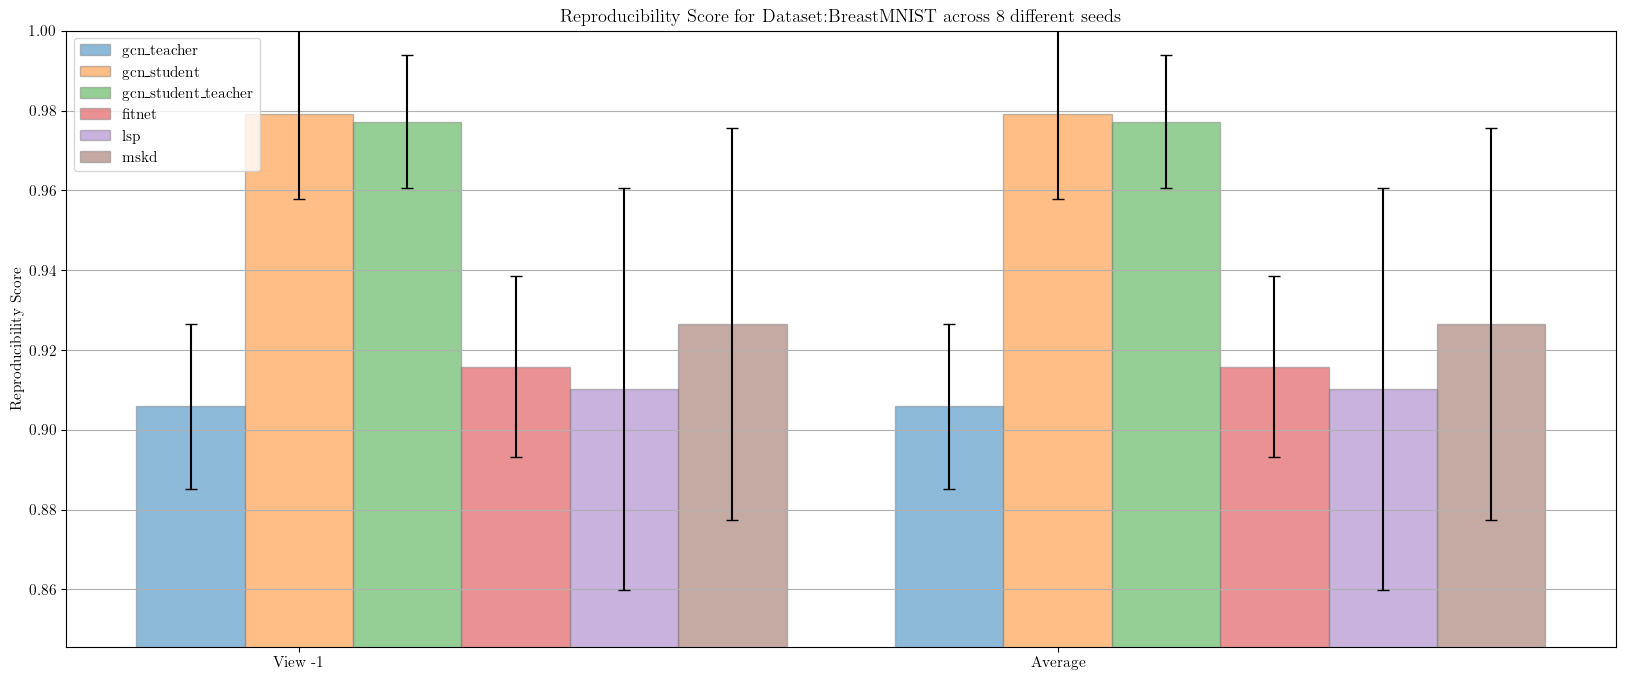

<Figure size 2000x800 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="BreastMNIST"
views=[-1]
models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
model_args = [
    gcn_BreastMNIST_args, 
    gcn_student_BreastMNIST_args, 
    gcn_student_BreastMNIST_args, 
    gcn_fitnet_student_BreastMNIST_args,
    gcn_lsp_student_BreastMNIST_args,
    gcn_mskd_student_BreastMNIST_args
    ]
CV=["3Fold", "5Fold", "10Fold"]
runs=[0,1,2,4,5,6,7,8]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

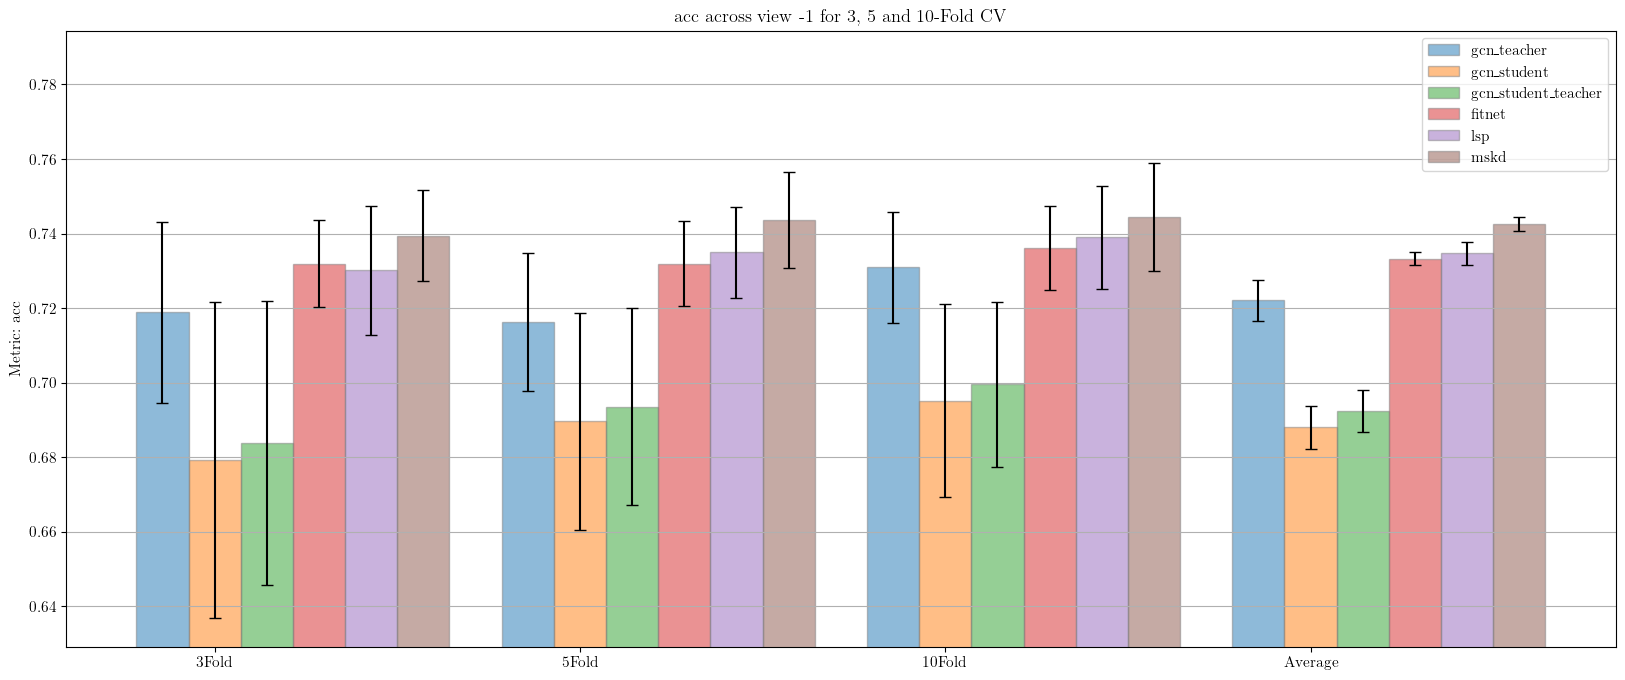

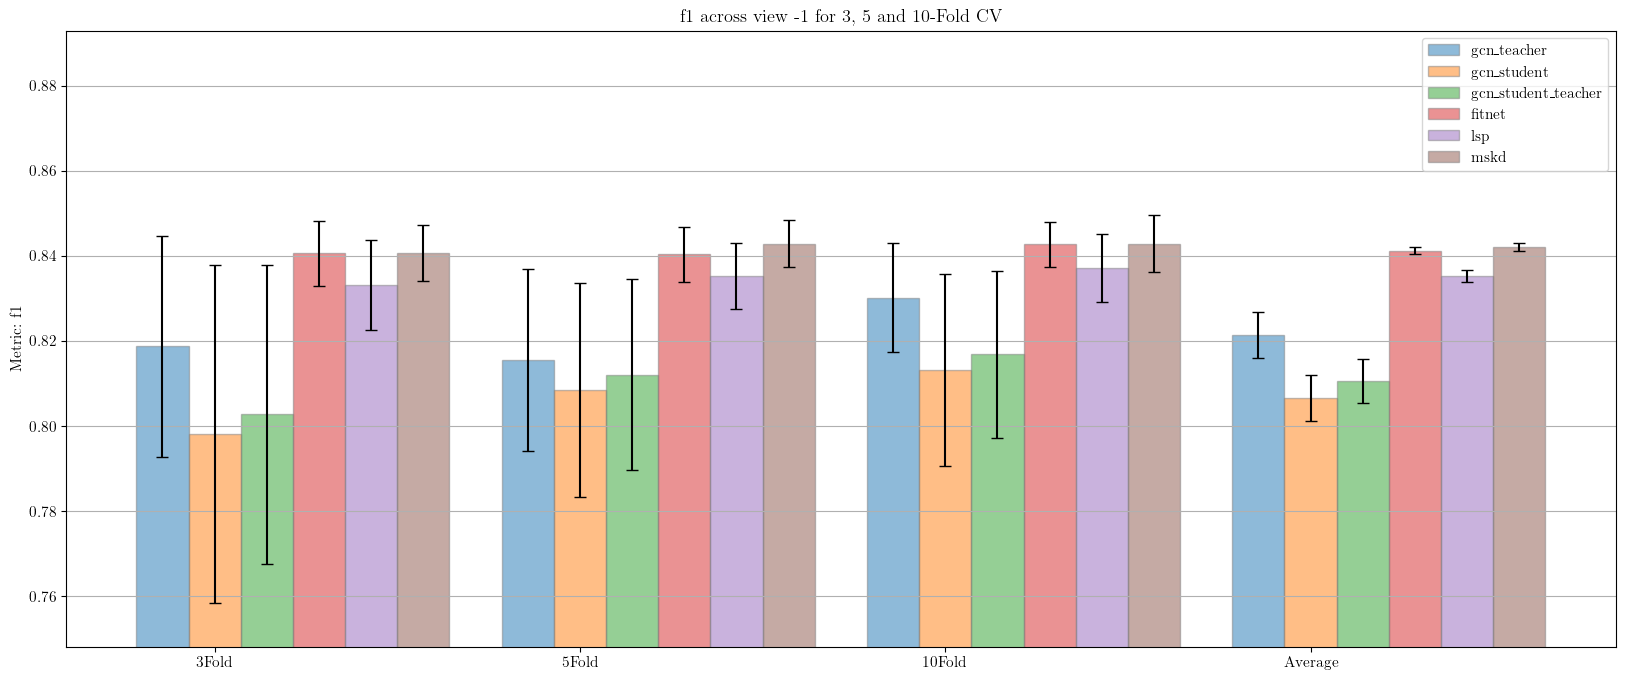

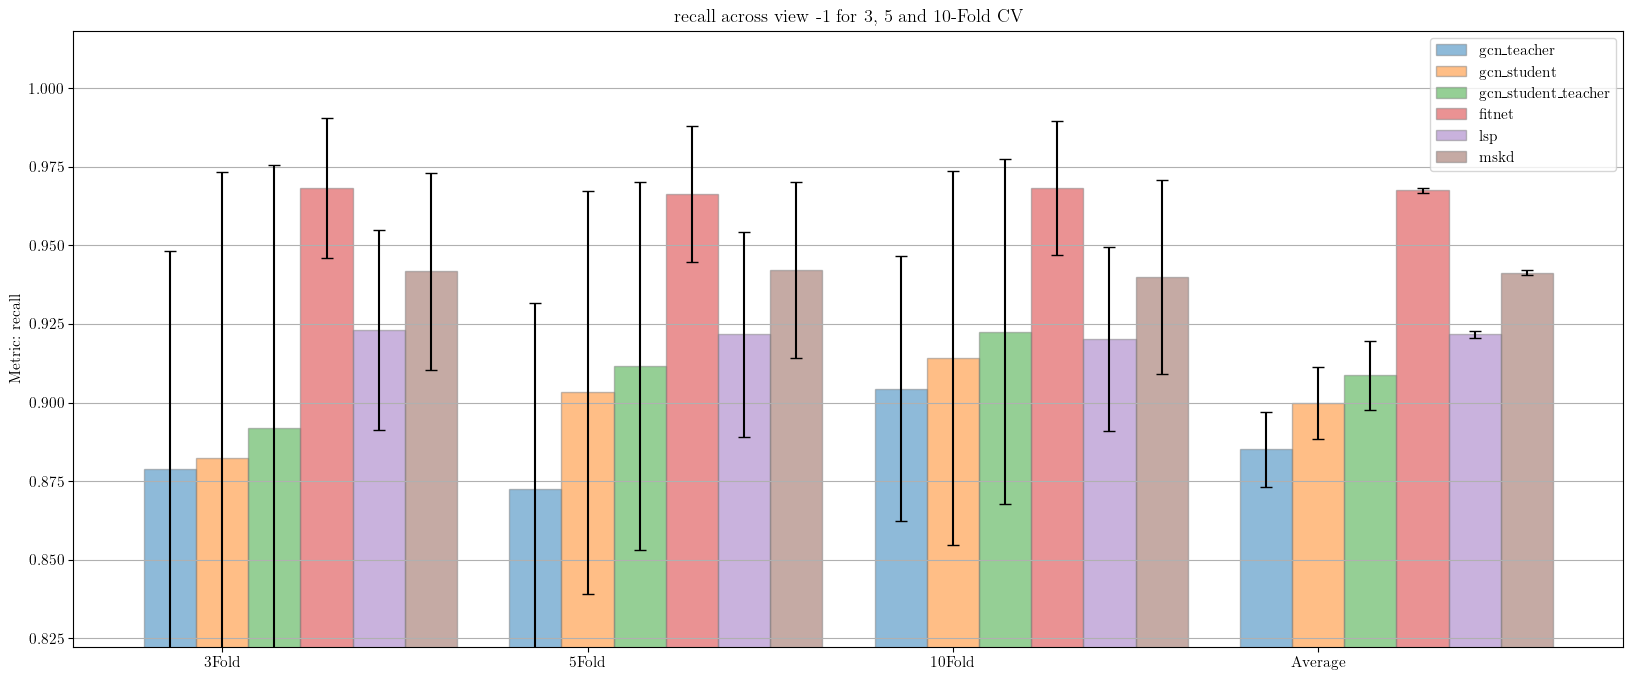

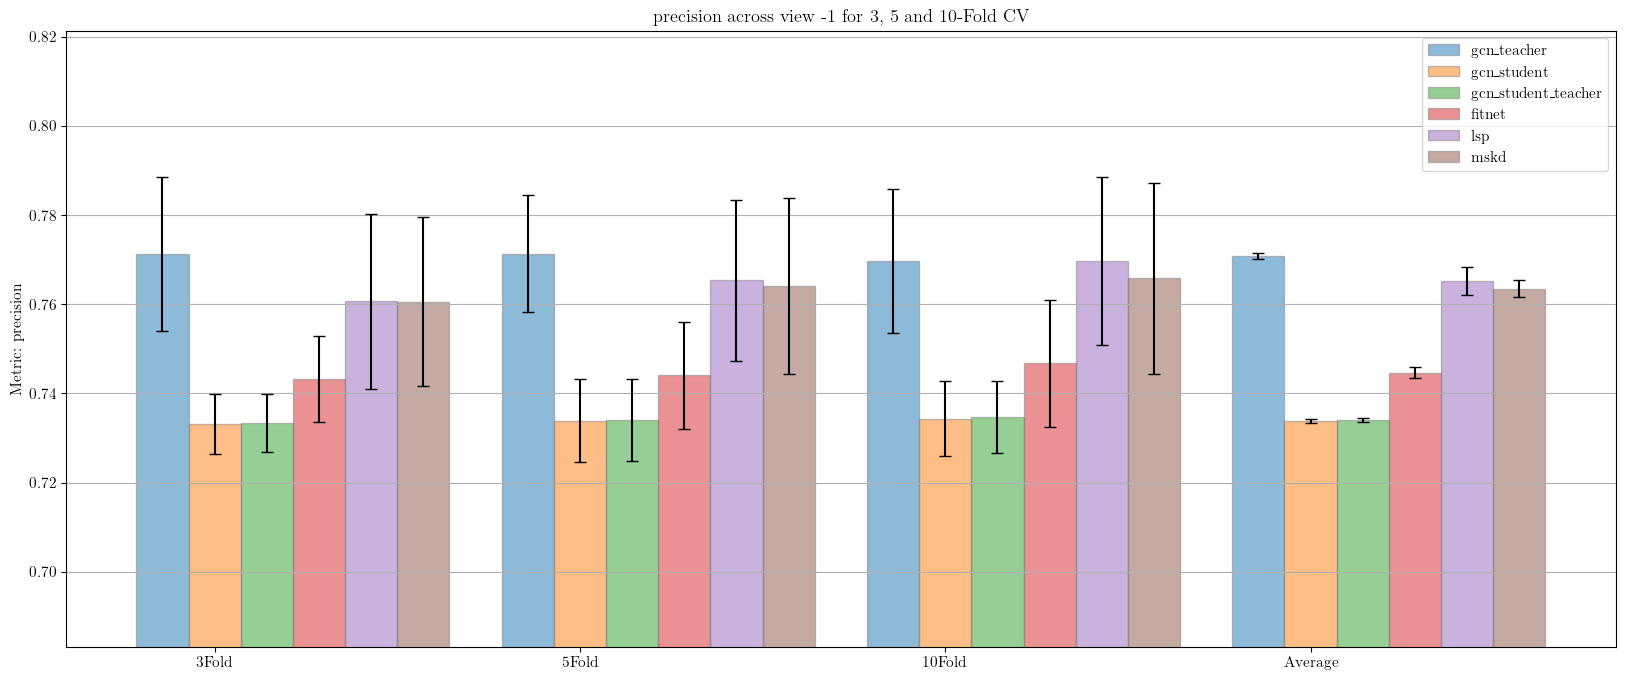

<Figure size 2000x800 with 0 Axes>

In [9]:
for view in [-1]:
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="f1", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
